# V471TAU

## ORBITAL PARAMSS TRY



In [20]:
lev_K = (148.0,150.0)
lev_vgamma = (33., 38.)
sigma_errorbar=1

### DATA IN 2004  

In [28]:
# load modules
import numpy as N
import matplotlib.pyplot as P
from scipy.optimize import leastsq
import cmocean as cm
import matplotlib.font_manager
P.style.use(['seaborn-white', 'seaborn-paper', 'seaborn-ticks'])
matplotlib.rc("font", family="Times New Roman", size=20)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#Define the number of sigmas that you want to consider 
nsigma=20.

# Read file with informations in each run
K, phase, vgamma, chisq, s, sp_ph, test, cool, hot = N.genfromtxt('data/search_ORBITAL_2004.txt', unpack=True)


#Change to oeq and do
period =  0.5211833875 # in days
Omega0 = 2*N.pi/period

# Now we need to find the number of points to find the error bar
cycle, vr, snI, I, cycleV, vrV, snV, V = rstokes('data/v471tau_04.ss')
count=0
for i in range(len(cycle)):
    count += I[i].shape[0]
    
#Compute the corresponding variation in "reduced chisq"
dchisq = nsigma**2*2.3/count

# Set global min of spot coverage
vmin = sp_ph.min()
sp_ph /= vmin
print(vmin)

#Set levels for plotting
lev = [1. + isigma**2*(2.3/count) for isigma in range(int(nsigma)+1)]
cut_sigma = int(nsigma) + 2
lev_1 = [1. + isigma**2*(2.3/count) for isigma in range(1,cut_sigma,2)]

#select data within the conditions:
ic = N.bitwise_and(chisq <= 1.0005, test <= 0.005)
K = K[ic]; vgamma = vgamma[ic]; chisq = chisq[ic]; s = s[ic]; sp_ph = sp_ph[ic] 
test = test[ic]; cool = cool[ic]; hot = hot[ic]

#we also add another condition for the data (optional):
isp = N.bitwise_and(sp_ph >= 1.00*vmin, sp_ph <= (1. + cut_sigma**2*3.53/count))
K = K[isp]; vgamma = vgamma[isp]; chisq = chisq[isp]; s = s[isp]; sp_ph = sp_ph[isp] 
test = test[isp]; cool = cool[isp]; hot = hot[isp]

# Create a mesh and create new matrix with mesh's shape
x, y = N.meshgrid(N.unique(K), N.unique(vgamma))
m_z = N.ones_like(x)*9999.
m_test = N.ones_like(x)*9999.

for i in range(sp_ph.shape[0]):
    indx = N.bitwise_and(x == K[i], y == vgamma[i])
    m_z[indx] = sp_ph[i]
    m_test[indx] = test[i]

mask = m_z > (1. + cut_sigma**2*3.53/count)
z=N.ma.array(m_z, mask=mask)  
mask1 = m_test >= 1.
c_test=N.ma.array(m_test, mask=mask1)  

print(' Number of points in the fit: ', K.shape[0])
print('\n The lowest spot in the data was at:')
print('K = ', K[sp_ph.argmin()], 'Vgamma = ', vgamma[sp_ph.argmin()])

# find center in the 2d-plane
optimize_func = lambda x: x[0]*K**2 + x[1]*K + x[2]*vgamma**2 + x[3]*vgamma \
                            + x[4]*K*vgamma + x[5] - sp_ph
coef = leastsq(optimize_func, [1.,1.,1.,1.,1.,1.])[0]
a, b, c, d, e, f = coef.copy()
best_x = 1./(4*a*c/e - e)*(d - 2.*c*b/e)
best_y = 1./(4*a*c/e - e)*(b - 2.*a*d/e)
dx = 1./N.sqrt(a - e**2/(4*c))
dy = 1./N.sqrt(c - e**2/(4*a))

dx /= N.sqrt(count)
dy /= N.sqrt(count)

w_min = a*best_x**2 + b*best_x + c*best_y**2 + d*best_y + e*best_x*best_y + f 
res = a*K**2 + b*K + c*vgamma**2 + d*vgamma + e*K*vgamma + f - sp_ph


print('Position of the center on this plane:')
print(r'K = %.3f and Vgamma = %.3f' %(best_x, best_y))
print('dK = %.3f and d(Vgamma) = %1.3f' %(dx, dy))


print('\n Min Spot from fit:')
print('Min Spot = ', w_min)
print('RMS = ', N.sqrt(N.mean(res**2)))
print('RMS x dchisq =', N.sqrt(N.mean(res**2))*(count/2.3)) #2params

0.2462027
 Number of points in the fit:  91

 The lowest spot in the data was at:
K =  149.3 Vgamma =  34.4
Position of the center on this plane:
K = 149.546 and Vgamma = 35.625
dK = 0.018 and d(Vgamma) = 0.021

 Min Spot from fit:
Min Spot =  1.0347819221254895
RMS =  0.012145785711213984
RMS x dchisq = 146.79502226101147


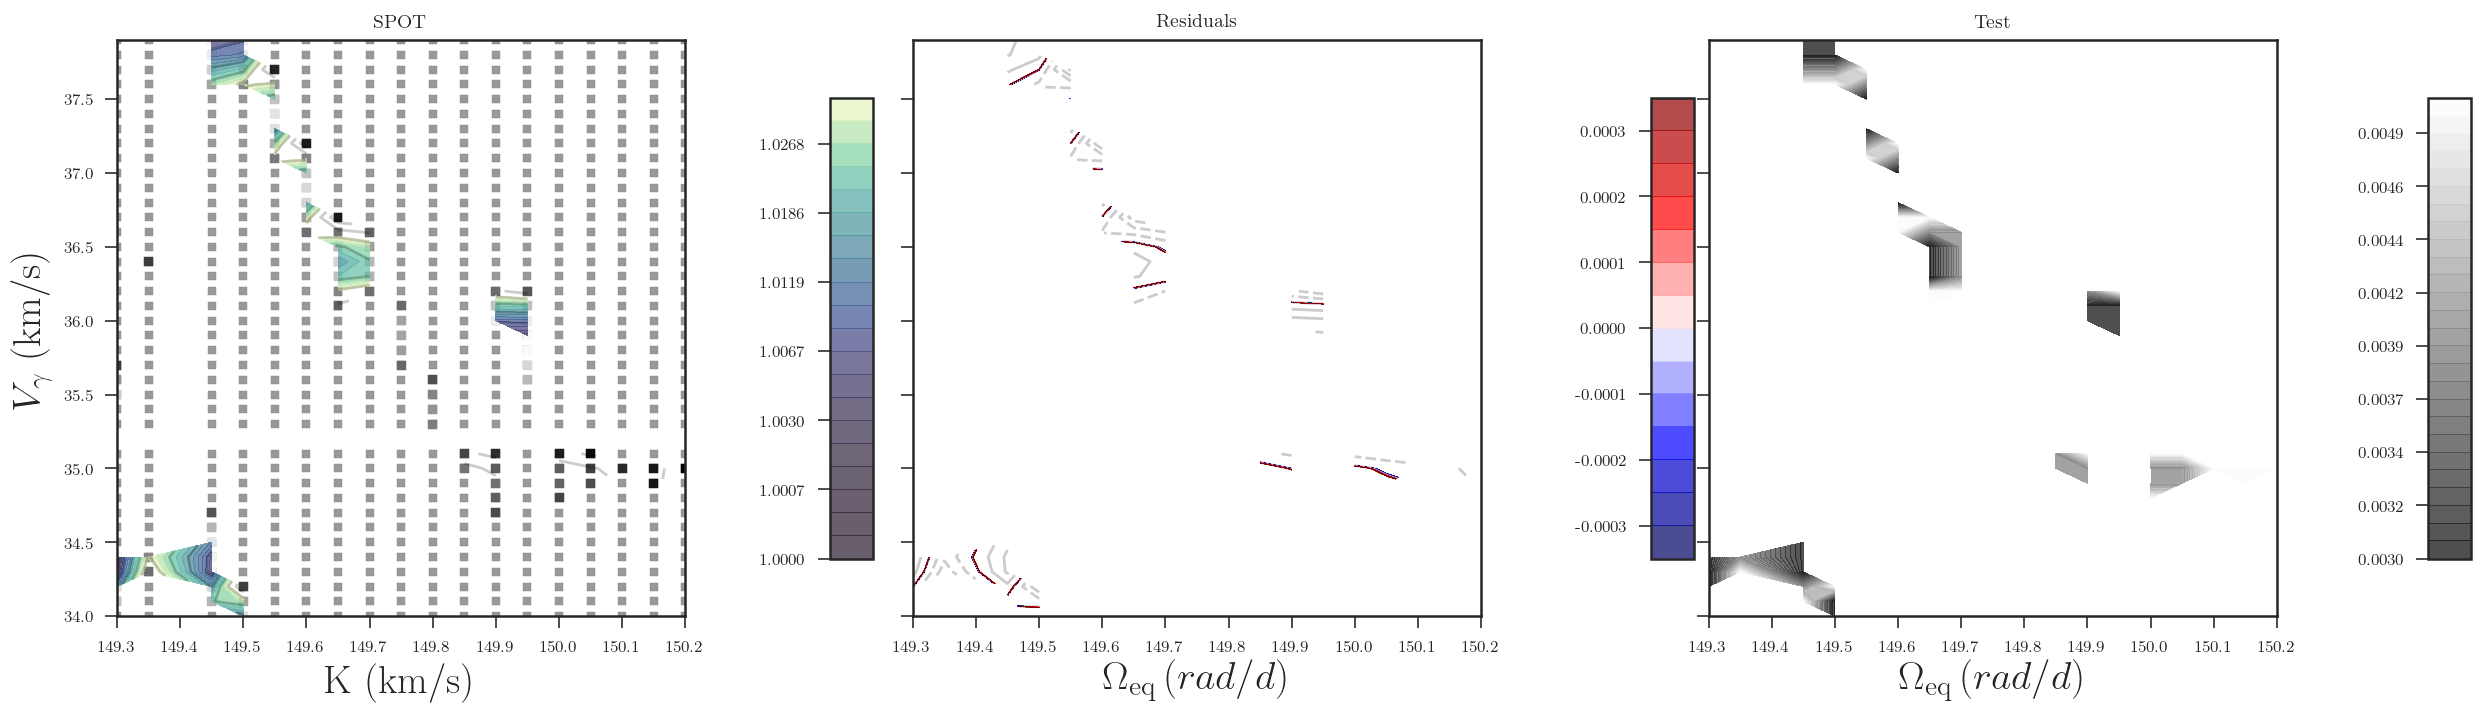

In [29]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean
cmap = cmocean.cm.deep_r 

fig, ax = P.subplots(1,3, figsize=(15,4), sharey=True)
ax[0].scatter(x, y, marker = 's', s=20, color='gray', alpha=0.8)
ax[0].scatter(x, y, c=z, marker = 's', s=20, alpha=1.)
ax[0].set_title('SPOT')
im = ax[0].contourf(x, y, z, levels=lev, cmap=cmap, alpha=0.7)
ax[0].contour(x, y, z, colors='k', alpha=0.2)
# Add colorbar
divider = make_axes_locatable(ax[0])
cax = fig.add_axes([0.33, 0.10, 0.02, 0.8])
cbar = fig.colorbar(im, cax = cax, ticklocation = 'left', format = '%.4f')
cbar.ax.set_xticklabels([r'%d \sigma' %i for i in range(0,int(nsigma)+1)])
ax[0].set_xlim((x.min(), x.max()))
ax[0].set_ylim((y.min(), y.max()))
ax[0].plot(best_x, best_y, 'x', color='k')
ax[0].set_xlabel(r'K (km/s)', fontsize=20)
ax[0].set_ylabel(r'$V_\gamma$ (km/s)', fontsize=20)

# Residual
res = a*x**2 + b*x + c*y**2 + d*y + e*x*y + f - z
ax[1].set_title('Residuals')
im1 = ax[1].contourf(x, y, res, levels=N.linspace(-1,1,15)*4.e-4, cmap='seismic', alpha=0.7)
# Add colorbar
divider = make_axes_locatable(ax[0])
cax1 = fig.add_axes([0.71, 0.10, 0.02, 0.8])
cbar = fig.colorbar(im1, cax = cax1, ticklocation = 'left', format = '%.4f')
ax[1].contour(x, y, res, colors='k', alpha=0.2)
ax[1].set_xlim((x.min(), x.max()))
ax[1].set_ylim((y.min(), y.max()))
ax[1].plot(best_x, best_y, 'x', color='k')
ax[1].set_xlabel(r'$\Omega_\mathrm{eq} \left(rad/d\right)$', fontsize=20)

# Test
ax[2].set_title('Test')
im2 = ax[2].contourf(x, y, c_test, 30, cmap='gray', alpha=0.7)
# Add colorbar
divider = make_axes_locatable(ax[0])
cax2 = fig.add_axes([1.07, 0.10, 0.02, 0.8])
cbar = fig.colorbar(im2, cax = cax2, ticklocation = 'left', format = '%.4f')
ax[2].set_xlim((x.min(), x.max()))
ax[2].set_ylim((y.min(), y.max()))
ax[2].plot(best_x, best_y, 'x', color='k')
ax[2].set_xlabel(r'$\Omega_\mathrm{eq} \left(rad/d\right)$', fontsize=20)
fig.subplots_adjust(left = .0, right = 1., top = 1., bottom = .0, wspace = .4, hspace = .1)
#P.tight_layout()

P.show()

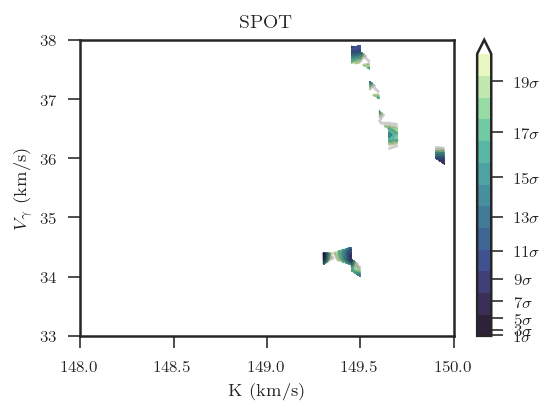

In [30]:
fig, ax = P.subplots(1,1, figsize=(4,3), sharey=True)
cmap.set_over('white')
#ax.scatter(K, vgamma, marker = 's', s=20, color='gray', alpha=0.8)
ax.set_title('SPOT')
im = ax.contourf(x, y, z, levels=N.linspace(lev[0], lev[-1], 14,endpoint=True), cmap=cmap, alpha=1., extend='max')
ax.contour(x, y, z, levels=lev_1, colors='k', alpha=0.2)
# Add colorbar
cbar = fig.colorbar(im, ticks=lev_1, ticklocation = 'right', format = '%1.4f')
cbar.ax.set_yticklabels([r'$ %1d \sigma$' %isig for isig in range(1,cut_sigma,2)])
ax.set_xlim(lev_K); ax.set_ylim(lev_vgamma)
ax.plot(best_x, best_y, 'X', color='w')
ax.set_xlabel(r'K (km/s)')
ax.set_ylabel(r'$V_\gamma$ (km/s)')
P.tight_layout()